# MNIST Dataset

Classify handwritten digits (0-9) images into their respective classes.

In [1]:
import gzip, pickle
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics as skm

# reading the input file
with gzip.open('mnist_rowmajor.pkl.gz', 'rb') as data_fh:
    data = pickle.load(data_fh, encoding='latin1')

In [2]:
# creating numpy array of training data, images with their corresponding labels
training_data = np.array(list(zip(data['images_train'], data['labels_train'])))
# creating numpy array of testing data, images with their corresponding labels
testing_data = np.array(list(zip(data['images_test'], data['labels_test'])))

## I. Exploring data

In [3]:
# number of instances in the training data
training_data.shape

(60000, 2)

This means there are 60,000 training data points. Each point has 2 values first is the image array and second is it's label.

In [4]:
# size of the image array
training_data[0][0].size

784

Each image is one dimensional array of length 784.

### Visualizing image and checking label

array([7], dtype=uint8)

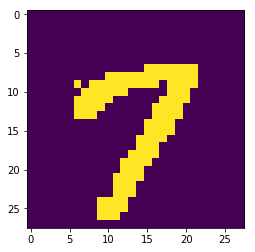

In [5]:
# visualizing the data
image = list()
for value in training_data[8,0]:
    if value > 0:
        image.append(1)
    else:
        image.append(0)

plt.imshow(np.array(image).reshape(28, 28))
training_data[8,1] 

Here, we are visualizing the image at postion 8 in training_data array. The sign function is used to create a binary representation of the array and then array is converted in a 28x28 grid and displayed in a plot.

### Splitting the training data into train and dev sets using stratified sampling
We will create the development set by assigning them 15% of the training data.

In [6]:
# counting how many input points are there under each unique label
labels_list, counts = np.unique(training_data[:,1], return_counts=True)
labels_list, counts

(array([array([0], dtype=uint8), array([1], dtype=uint8),
        array([2], dtype=uint8), array([3], dtype=uint8),
        array([4], dtype=uint8), array([5], dtype=uint8),
        array([6], dtype=uint8), array([7], dtype=uint8),
        array([8], dtype=uint8), array([9], dtype=uint8)], dtype=object),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949],
       dtype=int64))

We have done this for performing stratified sampling. We will take 15% of the data points from each of the digit groups.

In [7]:
# split data into according to labels 
unique_groups = list()

for key in labels_list:
    unique_groups.append(training_data[training_data[:,1]==key])

# all the input data under label [0]
unique_groups[0]

array([[array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        ,

We have seperated the data based on each input sample.

In [8]:
# taking first N points from each of the groups to form the int_dev i.e. development set 
# where N = 15% of total points under that group and 
# same time forming the int_train i.e. training set with the remaining points
int_dev = list()
int_train = list()

for key in labels_list:
    int_train.append(unique_groups[key[0]][round(0.15*len(unique_groups[key[0]])) :])
    int_dev.append(unique_groups[key[0]][: round(0.15*len(unique_groups[key[0]])) ])
    
int_dev = np.array(int_dev)
int_train = np.array(int_train)

In [9]:
len(int_train[0])

5035

In [10]:
len(int_dev[0])

888

This shows the distribution that int_dev has 888 input images having \[0\] label and int_train has 5035 images having \[0\] label, total of which is 5923 that matches the total instances under label \[0\] in the provided training data.
int_train\[1\] and int_dev\[1\] correspond to the 15% split for elements under label \[1\] and so on for all the labels.

In [11]:
# flatten the lists 
int_train = [item for sublist in int_train for item in sublist]
int_dev = [item for sublist in int_dev for item in sublist]

In [12]:
# shuffle the content of both the lists
import random 

random.shuffle(int_dev)
random.shuffle(int_train)

Now out splits are ready to use.

### Visualize the splits 

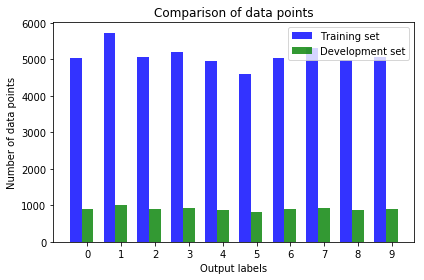

In [13]:
dev_items, dev_count = np.unique([item[1] for item in int_dev], return_counts=True)
train_items, train_count = np.unique([item[1] for item in int_train], return_counts=True)

# create plot
fig, ax = plt.subplots()
index = np.arange(len(dev_items))
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, train_count, bar_width,
alpha=opacity,
color='b',
label='Training set')
 
rects2 = plt.bar(index + bar_width, dev_count, bar_width,
alpha=opacity,
color='g',
label='Development set')
 
plt.xlabel('Output labels')
plt.ylabel('Number of data points')
plt.title('Comparison of data points')
plt.xticks(index + bar_width, (dev_items))
plt.legend()
 
plt.tight_layout()
plt.show()

## II. Baseline Classifier - Most Frequent

In [14]:
# separating training images and labels into different lists
images_train = [item[0] for item in int_train]
labels_train = [item[1] for item in int_train]

# separating development images and labels into different lists
images_dev = [item[0] for item in int_dev]
labels_dev = [item[1] for item in int_dev]

In [15]:
def most_frequent_baseline_classifier(labels_train):
    ''' Function to build most frequent baseline classifier '''
    
    labels, element_counts = np.unique(labels_train, return_counts=True)
    return labels[np.argmax(element_counts)]

In [16]:
def predict_most_frequent(labels_dev, predicted_label):
    ''' Function to make prediction on development set using most frequent baseline classifier '''
    
    predicted_labels = list()
    for key in labels_dev:
        predicted_labels.append(predicted_label)
    return predicted_labels

In [17]:
# build most frequent baseline classifier using training data
predicted_label = most_frequent_baseline_classifier(labels_train)
# make prediction on development data
predicted_labels = predict_most_frequent(labels_dev, predicted_label)
predicted_labels

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,


In [18]:
# calculate accuracy
accuracy = skm.accuracy_score(labels_dev, predicted_labels)
accuracy

0.11233333333333333

## III. Multiclass Perceptron

### Standard perceptron

In [19]:
def multiclass_perceptron(training_data, epochs):
    ''' Function to build standard multiclass perceptron '''
    
    labels_list = np.unique([item[1] for item in training_data])
    
    # initialize weight vectors
    w = list()
    for i in labels_list:
        w.append(np.zeros(len(training_data[0][0])))
    
    for epoch in range(0, epochs):
        for x in training_data:
            # true label
            y = x[1][0]
            
            y_hats = list()
            # for each label calculate y_hat
            for i, label in enumerate(labels_list):
                # activation score 
                y_hats.append(np.dot(w[i], x[0]))
                
            # selecting the label with maximum value 
            y_hat = np.argmax(y_hats)

            # if incorrect prediction
            if y != y_hat:
                # increase correct label weight
                w[y] = w[y] + x[0]
                # decrease mispredicted weight
                w[y_hat] = w[y_hat] - x[0]
            
    # return the updated weights        
    return w

In [20]:
def predict_multiclass_perceptron(test_data, weights):  
    ''' Function to make prediction using multiclass perceptron '''
    
    predicted_labels = list()
    
    # for each x in test set
    for x in test_data:
        y_hats = list()
        # for each label calculate y_hat 
        # there is a weight for each label so iterate over each weight
        for i, label in enumerate(weights):
            # activation score 
            y_hats.append(np.dot(weights[i], x[0]))  
            
        # selecting the label with maximum value 
        y_hat = np.argmax(y_hats)
        predicted_labels.append(y_hat)
                
    # returning the list of predicted labels
    return predicted_labels

For testing the working of the algorithm, we have taken toy data which has some points which can be plotted in a 2d space. We have assigned them labels of 0 and 1. Our training set consists of 5 points and testing set consists of 3 points. We have taken linearly separable data here to prove that the model will converge.

In [21]:
# toy data
toy_train_data = [[[-1,1], [1]], [[-1,-1], [0]], [[0.5,0.5], [1]], [[1,-1], [1]], [[0.5,-1], [0]]]
toy_train_labels = [1, 0, 1, 1, 0]
toy_test_data = [[[-1,-2], [0]], [[1,1], [1]], [[2,-1],[1]]]
toy_test_labels = [0, 1, 1]

# build the perceptron using toy traning data 
updated_weights = multiclass_perceptron(training_data=toy_train_data, epochs=1)

# make predictions on toy test data based on the updated weights
predicted_labels = predict_multiclass_perceptron(test_data=toy_test_data, weights=updated_weights)
    
# calculate accuracy 
accuracy = skm.accuracy_score(toy_test_labels, predicted_labels)

accuracy

1.0

This data converges in 1 epoch itself so no need of going for more and because it is perfectly separable we have an accuracy of 1.

Using the input vector directly

[5, 10, 30, 50, 100]
[0.872, 0.8551111111111112, 0.8623333333333333, 0.8773333333333333, 0.8737777777777778]


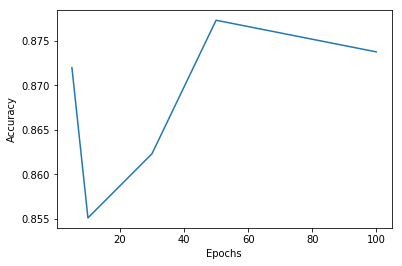

In [23]:
# epochs list 
epoch_list = [5, 10, 30, 50, 100]
# accuracy of each epoch
accuracies = list()

for epoch in epoch_list:
    # build the perceptron using traning data and current epoch
    updated_weights = multiclass_perceptron(training_data=int_train, epochs=epoch)
    # make predictions on development data based on the updated weights
    predicted_labels = predict_multiclass_perceptron(test_data=int_dev, weights=updated_weights)
    
    # calculate accuracy 
    accuracy = skm.accuracy_score(labels_dev, predicted_labels)
    accuracies.append(accuracy)  

print(epoch_list)
print(accuracies)

# plot graph of all the accuracies for comparison
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epoch_list, accuracies)
plt.show()

The algorithm is said to converge when the mispredictions are less and accuracy is high so we will select the epoch where we have the greatest accuracy i.e. 50

Using binary representation of the input vector

In [24]:
def convert_to_binary(vector):
    for x in vector:
        for i, value in enumerate(x[0]):
            if value > 0:
                x[0][i] = 1
    return vector

Above function converts the raw input data into binary. Here we have considered all the feilds having values greater than 0 to be 1 to generalize it.

In [25]:
# convert training data
bin_int_train = convert_to_binary(int_train)
# convert development data
bin_int_dev = convert_to_binary(int_dev)

[5, 10, 30, 50, 100]
[0.8607777777777778, 0.8802222222222222, 0.8396666666666667, 0.8758888888888889, 0.8497777777777777]


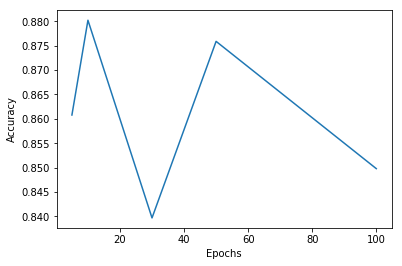

In [26]:
# epochs list 
epoch_list = [5, 10, 30, 50, 100]
# accuracy of each epoch
accuracies = list()

for epoch in epoch_list:
    # build the perceptron using traning data and current epoch
    updated_weights = multiclass_perceptron(training_data=bin_int_train, epochs=epoch)
    # make predictions on development data based on the updated weights
    predicted_labels = predict_multiclass_perceptron(test_data=bin_int_dev, weights=updated_weights)
    
    # calculate accuracy 
    accuracy = skm.accuracy_score(labels_dev, predicted_labels)
    accuracies.append(accuracy)  

print(epoch_list)
print(accuracies)

# plot graph of all the accuracies for comparison
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epoch_list, accuracies)
plt.show()

Here, the maximum accuracy is at epoch 10, but the difference between accuracies at epoch 50 for direct input and binary input is less. So we can best generalize the optimal solution at epoch 50 and using direct input feature vectors.

### Voted Perceptron

In [27]:
def voted_multiclass_perceptron(training_data, epochs):
    ''' Function to build voted multiclass perceptron '''
    
    labels_list = np.unique([item[1] for item in training_data])
    
    # initial weights
    w = list()
    for i in labels_list:
        w.append(np.zeros(len(training_data[0][0])))
        
    # survival times
    c_k = list()
    c = 1
    # averaged weights
    w_k = list()
            
    for iteration in range(0, epochs):
        for x in training_data:
            # true label
            y = x[1][0]
            y_hats = list()
            # for each label calculate y_hat
            for i, label in enumerate(labels_list):
                # activation score 
                y_hats.append(np.dot(w[i], x[0]))    
            # selecting the label with maximum value 
            y_hat = np.argmax(y_hats)

            # if correct prediction
            if y == y_hat:
                c = c + 1
            # if incorrect prediction
            else:
                # keep history of weights
                w_k.append(w)
                c_k.append(c)
                c = 1
                
                # increase correct label weight
                w[y] = w[y] + x[0]
                    
                # decrease mispredicted weight
                w[y_hat] = w[y_hat] - x[0]
                
    return w_k, c_k

In [28]:
def predict_voted_perceptron(test_data, weights, survival_times):
    ''' Function to make predictions using voted multiclass perceptron '''
    
    predicted_labels = list()
    
    labels_list = np.unique([item[1] for item in training_data])
    
    c = survival_times
    
    for x in test_data:
        labels_votes = list()
        for i in labels_list:
            labels_votes.append(0)
            
        # for each k in weights
        for k, weight in enumerate(weights):
            y_hats = list()
            # for each individual weight of label
            for w in weight:
                y_hats.append(np.dot(w, x[0]))
            # selecting the label with maximum value 
            y_hat = np.argmax(y_hats)
            labels_votes[y_hat] = labels_votes[y_hat] + c[k]
        
        y = np.argmax(labels_votes)
        predicted_labels.append(y)
        
    return predicted_labels

Using input vector directly

To check the working of algorithm we have used toy data as we did for standard perceptron.

In [29]:
toy_train_data = [[[-1,1], [1]], [[-1,-1], [0]], [[0.5,0.5], [1]], [[1,-1], [1]], [[0.5,-1], [0]]]
toy_train_labels = [1, 0, 1, 1, 0]
toy_test_data = [[[-1,-2], [0]], [[1,1], [1]], [[2,-1],[1]]]
toy_test_labels = [0, 1, 1]

# build the perceptron using traning data and current epoch
updated_weights, survival_times = voted_multiclass_perceptron(training_data=toy_train_data, epochs=1)

# make predictions on development data based on the updated weights and survival times
predicted_labels = predict_voted_perceptron(test_data=toy_test_data, weights=updated_weights, survival_times=survival_times)
    
# calculate accuracy 
accuracy = skm.accuracy_score(toy_test_labels, predicted_labels)
accuracy

1.0

As we can see, data is linearly separable so the accuracy is 1. 

In [30]:
# build the perceptron using traning data
updated_weights, survival_times = voted_multiclass_perceptron(training_data=int_train, epochs=1)

# make predictions on development data based on the updated weights and survival times
predicted_labels = predict_voted_perceptron(test_data=int_dev, weights=updated_weights, survival_times=survival_times)
    
# calculate accuracy 
accuracy = skm.accuracy_score(labels_dev, predicted_labels)
accuracy

0.8582222222222222

## IV. Evaluating above models on Test data

### Most frequent baseline classifier

In [31]:
train_images = data['images_train']
train_labels = data['labels_train']
test_images = data['images_test']
test_labels = data['labels_test']

In [32]:
train_images.shape

(60000, 784)

In [33]:
test_images.shape

(10000, 784)

In [34]:
# build most frequent baseline classifier using training data
predicted_label = most_frequent_baseline_classifier(train_labels)

# make prediction on test data
predicted_labels = predict_most_frequent(test_labels, predicted_label)

In [35]:
# calculate accuracy 
accuracy = skm.accuracy_score(test_labels, predicted_labels)
accuracy

0.1135

In [36]:
# calculate precision
precision = skm.precision_score(test_labels, predicted_labels, average=None)
precision

C:\Users\aishwarya\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([0.    , 0.1135, 0.    , 0.    , 0.    , 0.    , 0.    , 0.    ,
       0.    , 0.    ])

In [37]:
# calculate recall
recall = skm.recall_score(test_labels, predicted_labels, average=None)
recall

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [38]:
# calculate f1 score
f1score = skm.f1_score(test_labels, predicted_labels, average=None)
f1score

C:\Users\aishwarya\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


array([0.       , 0.2038617, 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       ])

In [40]:
# confusion matrix
matrix = skm.confusion_matrix(test_labels, predicted_labels)
matrix

array([[   0,  980,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1135,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1032,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1010,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  982,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  892,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  958,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1028,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  974,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 1009,    0,    0,    0,    0,    0,    0,    0,    0]],
      dtype=int64)

### Standard Multiclass Perceptron

In [41]:
training_data.shape

(60000, 2)

In [42]:
testing_data.shape

(10000, 2)

Best configuration - Using standard multiclass perceptron with 50 epochs on the input data directly.

In [43]:
# build the perceptron using traning data and epoch
updated_weights = multiclass_perceptron(training_data=training_data, epochs=50)

# make predictions on test data based on the updated weights
predicted_labels = predict_multiclass_perceptron(test_data=testing_data, weights=updated_weights)

In [44]:
# calculate accuracy 
accuracy = skm.accuracy_score(test_labels, predicted_labels)
accuracy

0.8482

In [45]:
# calculate recall
recall = skm.recall_score(test_labels, predicted_labels, average=None)
recall

array([0.98673469, 0.98237885, 0.85658915, 0.88316832, 0.9694501 ,
       0.7544843 , 0.83402923, 0.7733463 , 0.83983573, 0.58176412])

In [46]:
# calculate f1 score
f1score = skm.f1_score(test_labels, predicted_labels, average=None)
f1score

array([0.92757794, 0.94451504, 0.87265548, 0.8715193 , 0.75856574,
       0.82678133, 0.89624229, 0.85621971, 0.8175912 , 0.68977673])

In [47]:
# confusion matrix
matrix = skm.confusion_matrix(test_labels, predicted_labels)
matrix

array([[ 967,    1,    0,    3,    3,    0,    2,    0,    3,    1],
       [   1, 1115,    5,    3,    1,    1,    3,    2,    4,    0],
       [  19,   19,  884,   28,   30,    2,    4,    4,   35,    7],
       [  13,    7,   23,  892,    8,   14,    1,    7,   39,    6],
       [   3,    9,    2,    1,  952,    0,    3,    1,    7,    4],
       [  29,   11,    2,   45,   26,  673,   10,    7,   85,    4],
       [  31,    2,   39,    2,   61,   18,  799,    1,    5,    0],
       [  13,   13,   24,   27,   59,    1,    0,  795,   14,   82],
       [  13,   34,   14,   23,   40,   23,    3,    4,  818,    2],
       [  16,   15,    1,   13,  348,    4,    0,    8,   17,  587]],
      dtype=int64)

In [48]:
# calculate precision 
precision = skm.precision_score(test_labels, predicted_labels, average=None)
precision

array([0.87511312, 0.90946166, 0.88933602, 0.86017358, 0.62303665,
       0.91440217, 0.96848485, 0.95898673, 0.79649464, 0.84704185])